In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF

#### 각 크립토 시장 데이터 불러오기

In [11]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

#### Q(투자자 기대 수익률) 불러오기

In [16]:
# Q 벡터를 pickle 파일에서 불러오기
with open('q_vector_epoch_minmax_price.pkl', 'rb') as f:
    Q = pickle.load(f)

dates = pd.date_range(start='2023-06-01', end='2023-12-31')
# Q 딕셔너리를 DataFrame으로 변환
Q_df = pd.DataFrame.from_dict(Q, orient='index', columns=dates)

# [[]] 구조를 제거하고 단일 값으로 변환
for col in Q_df.columns:
    Q_df[col] = Q_df[col].apply(lambda x: x[0][0] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], list) and len(x[0]) > 0 else x)

Q_df

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,0.537010,0.520112,0.507253,0.504076,0.509662,0.499144,0.490367,0.477137,0.472331,0.486403,...,1.000549,0.996487,0.992823,0.983445,0.974117,0.953246,0.954305,0.957572,0.955619,0.938117
ETH,0.671836,0.650850,0.655225,0.658619,0.658181,0.634643,0.641779,0.631594,0.623718,0.610225,...,0.930966,0.957513,0.943915,0.917207,0.918990,0.918210,0.959880,0.986751,0.970820,0.943585
BNB,0.816955,0.790846,0.772590,0.731385,0.701758,0.562395,0.532155,0.437550,0.412101,0.396147,...,0.511709,0.496136,0.511547,0.544250,0.621609,0.812571,0.897630,0.857213,0.794951,0.826249
DOT,0.391738,0.377955,0.385401,0.391988,0.388656,0.349073,0.360521,0.321796,0.310983,0.306245,...,0.928029,0.875073,0.937114,0.961872,0.987488,0.940415,0.900807,0.861591,0.861378,0.879833
SOL,0.291270,0.284932,0.286691,0.284632,0.295541,0.293004,0.278205,0.256848,0.240347,0.230622,...,0.906163,0.948748,0.965438,0.977349,0.984975,0.974386,0.947020,0.924227,0.922869,0.913811
FTT,0.069029,0.059444,0.063777,0.057761,0.064971,0.044560,0.034689,0.036588,0.074970,0.063198,...,0.773767,0.747534,0.729674,0.720121,0.709718,0.687310,0.668818,0.637533,0.614288,0.646146
XRP,0.420150,0.393099,0.404634,0.410479,0.437472,0.420571,0.461614,0.453760,0.459181,0.467152,...,0.617924,0.618418,0.607271,0.582926,0.624710,0.610601,0.630255,0.641296,0.635918,0.634961
UNI,0.325027,0.313314,0.329409,0.326310,0.301246,0.252931,0.252552,0.194825,0.211089,0.206175,...,0.670413,0.709358,0.694021,0.795741,0.821130,0.888336,0.868765,0.967882,0.922224,0.858957


In [13]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    
    del df['고가']
    del df['시가']
    del df['저가']
    del df['거래량']
    del df['변동 %']
    # 날짜 열을 datetime 객체로 변환
    df['created_at'] = pd.to_datetime(df['날짜'])
    del df['날짜']
    if not pd.api.types.is_string_dtype(df['종가']):
        df['종가'] = df['종가'].astype(str)

    # 문자열에서 쉼표 제거 후 float 타입으로 변환
    df['종가'] = df['종가'].str.replace(',', '').astype(float)
    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2

In [14]:
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
returns = pd.DataFrame(index=all_dates)

# StandardScaler 인스턴스 생성
scaler = MinMaxScaler()

for ticker, df in filtered_dfs.items():
    df.set_index('created_at', inplace=True)  # 'created_at'을 인덱스로 설정
    df = df.reindex(all_dates)  # 모든 날짜에 대해 데이터프레임을 재정렬
    
    # '변동 %' 데이터를 100으로 나누고 로그 변환 적용
    # df['종가'] = df['변동 %'].replace(',','').astype(float) / 100  # 쉼표 제거 후 float 타입으로 변환
    df['종가'] = np.log1p(df['종가'])  # 로그 변환 적용

    # StandardScaler를 적용하여 데이터 스케일링
    scaled_returns = scaler.fit_transform(df[['종가']])

    # 스케일링된 데이터를 데이터프레임에 추가
    returns[ticker] = scaled_returns

# 반환된 데이터프레임 확인
print(returns)

                 BTC       ETH       BNB       DOT       SOL       FTT  \
2023-06-01  0.115342  0.436679  0.866077  0.368474  0.158996  0.051463   
2023-06-02  0.143258  0.491988  0.883993  0.382963  0.175867  0.066142   
2023-06-03  0.131986  0.473772  0.878991  0.395281  0.174383  0.051504   
2023-06-04  0.135276  0.471328  0.868234  0.390651  0.188172  0.064208   
2023-06-05  0.043059  0.373365  0.657148  0.339411  0.147652  0.024829   
...              ...       ...       ...       ...       ...       ...   
2023-12-27  0.970503  1.000000  1.000000  0.935905  0.940859  0.686992   
2023-12-28  0.934837  0.966738  0.991928  0.900986  0.918120  0.637827   
2023-12-29  0.913532  0.921944  0.928504  0.882339  0.938079  0.613292   
2023-12-30  0.916240  0.914391  0.949387  0.889585  0.917945  0.689856   
2023-12-31  0.921943  0.904537  0.917284  0.870353  0.916916  0.629137   

                 XRP       UNI  
2023-06-01  0.136168  0.342852  
2023-06-02  0.191008  0.367055  
2023-06-03  

#### RMSE & MAE 계산

In [15]:
transposed_returns = returns.transpose()
transposed_returns

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,0.115342,0.143258,0.131986,0.135276,0.043059,0.142314,0.083564,0.094204,0.092746,0.049698,...,0.991690,0.981238,0.951428,0.975880,0.932012,0.970503,0.934837,0.913532,0.916240,0.921943
ETH,0.436679,0.491988,0.473772,0.471328,0.373365,0.464176,0.399743,0.416722,0.410148,0.296384,...,0.946801,0.931296,0.885992,0.893912,0.852399,1.000000,0.966738,0.921944,0.914391,0.904537
BNB,0.866077,0.883993,0.878991,0.868234,0.657148,0.688649,0.510839,0.533554,0.521805,0.330185,...,0.607537,0.606727,0.554295,0.574104,0.815123,1.000000,0.991928,0.928504,0.949387,0.917284
DOT,0.368474,0.382963,0.395281,0.390651,0.339411,0.367652,0.329927,0.330138,0.321010,0.218580,...,0.835130,0.889040,0.926007,1.000000,0.951715,0.935905,0.900986,0.882339,0.889585,0.870353
SOL,0.158996,0.175867,0.174383,0.188172,0.147652,0.156576,0.114860,0.121364,0.083500,0.034298,...,0.899504,0.946077,0.965804,1.000000,0.966367,0.940859,0.918120,0.938079,0.917945,0.916916
FTT,0.051463,0.066142,0.051504,0.064208,0.024829,0.034412,0.040911,0.114009,0.056227,0.007558,...,0.725498,0.739808,0.743078,0.733496,0.699205,0.686992,0.637827,0.613292,0.689856,0.629137
XRP,0.136168,0.191008,0.173373,0.224289,0.143658,0.206633,0.171807,0.188308,0.230773,0.137170,...,0.480386,0.466913,0.445693,0.541252,0.473796,0.508641,0.509033,0.476613,0.470328,0.455297
UNI,0.342852,0.367055,0.372083,0.352163,0.268606,0.282189,0.216803,0.239935,0.225978,0.060718,...,0.701663,0.689444,0.802114,0.829219,0.908378,0.885900,1.000000,0.952262,0.910837,0.882723


In [19]:
# 티커별로 오차 계산
tickers = ['BTC','ETH','BNB','DOT','SOL','FTT','XRP','UNI']
for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))
    print(f"{ticker} RMSE: {rmse}")

    # MAE 계산
    mae = mean_absolute_error(actual_returns, expected_returns)
    print(f"{ticker} MAE: {mae}")

BTC RMSE: 0.2991067584680228
BTC MAE: 0.2683990085009673
ETH RMSE: 0.23718882161062757
ETH MAE: 0.21475044812658312
BNB RMSE: 0.05863731921916595
BNB MAE: 0.045408534341745244
DOT RMSE: 0.030446359561601216
DOT MAE: 0.02149388173570354
SOL RMSE: 0.1074706872788157
SOL MAE: 0.09861057179671565
FTT RMSE: 0.027677914397254436
FTT MAE: 0.019650934374735585
XRP RMSE: 0.21542367260281167
XRP MAE: 0.19799196208658268
UNI RMSE: 0.04844641914585958
UNI MAE: 0.03486120901713461


#### R2 & MAPE 값 추가

In [20]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 결과를 저장하기 위한 딕셔너리
results = {}

for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]

    # 오차 지표 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))
    mae = mean_absolute_error(actual_returns, expected_returns)
    mape = calculate_mape(actual_returns, expected_returns)
    r_squared = r2_score(actual_returns, expected_returns)

    # 결과 저장
    results[ticker] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r_squared}

# 결과 출력
for ticker, metrics in results.items():
    print(f"{ticker}:")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  R2: {metrics['R2']:.2f}")
    print("------")


BTC:
  RMSE: 0.30
  MAE: 0.27
  MAPE: inf%
  R2: 0.01
------
ETH:
  RMSE: 0.24
  MAE: 0.21
  MAPE: inf%
  R2: 0.17
------
BNB:
  RMSE: 0.06
  MAE: 0.05
  MAPE: inf%
  R2: 0.91
------
DOT:
  RMSE: 0.03
  MAE: 0.02
  MAPE: inf%
  R2: 0.98
------
SOL:
  RMSE: 0.11
  MAE: 0.10
  MAPE: inf%
  R2: 0.83
------
FTT:
  RMSE: 0.03
  MAE: 0.02
  MAPE: inf%
  R2: 0.99
------
XRP:
  RMSE: 0.22
  MAE: 0.20
  MAPE: inf%
  R2: 0.16
------
UNI:
  RMSE: 0.05
  MAE: 0.03
  MAPE: inf%
  R2: 0.96
------


In [21]:
# 결과를 저장할 딕셔너리
results = {}
transformed_market_data = pd.DataFrame()

for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]
 

    transformed_market_data[ticker] = transposed_returns.loc[ticker] 

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))

    # MAE 계산
    mae = mean_absolute_error(actual_returns, expected_returns)

    # R2 계산
    r_squared = r2_score(actual_returns, expected_returns)

    # MAPE 계산
    mape = calculate_mape(actual_returns, expected_returns)

    # 결과 저장
    results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r_squared,
        'MAPE': mape
        }

#### 그래프 비교

In [22]:
transformed_market_data = transformed_market_data.transpose()

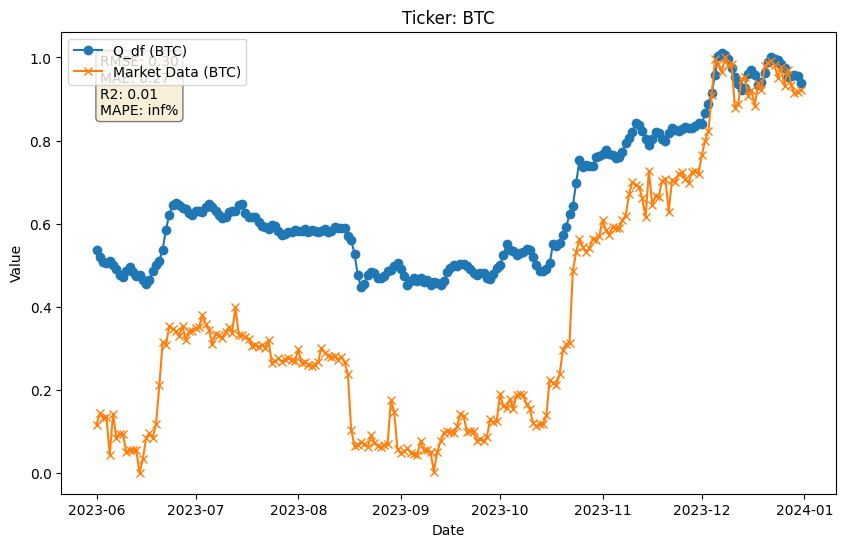

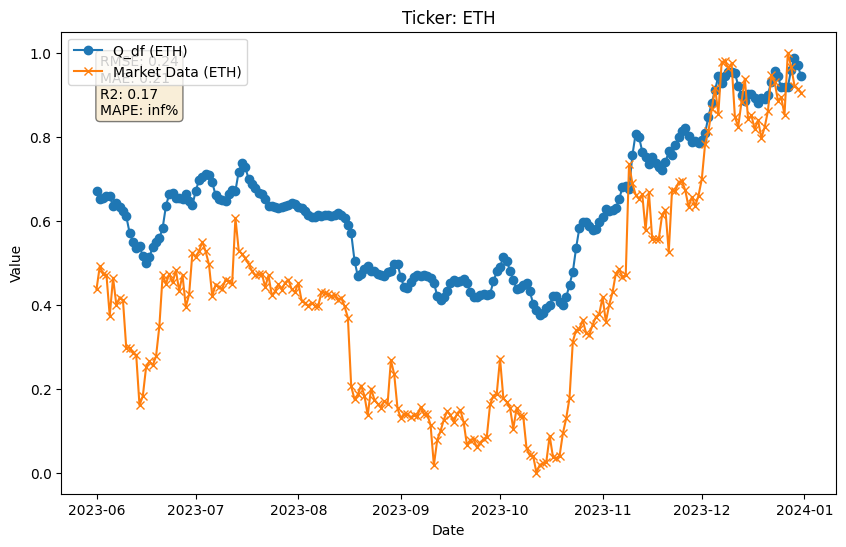

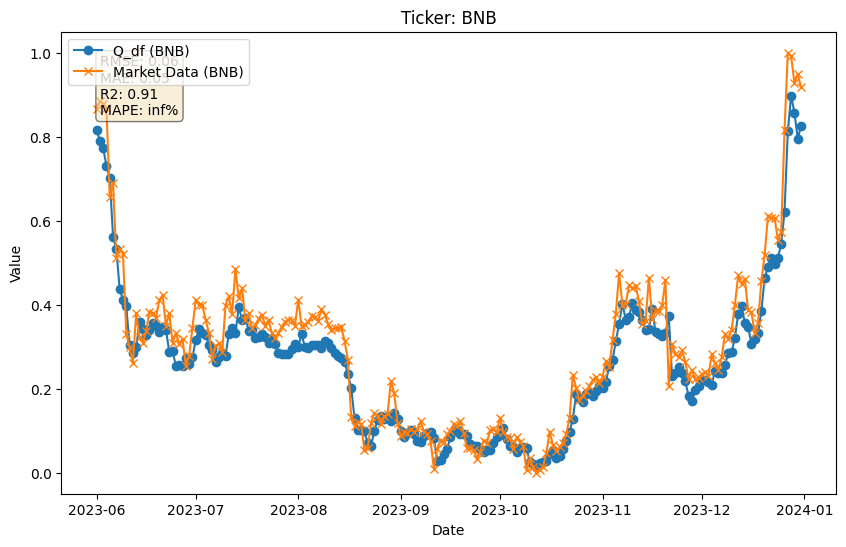

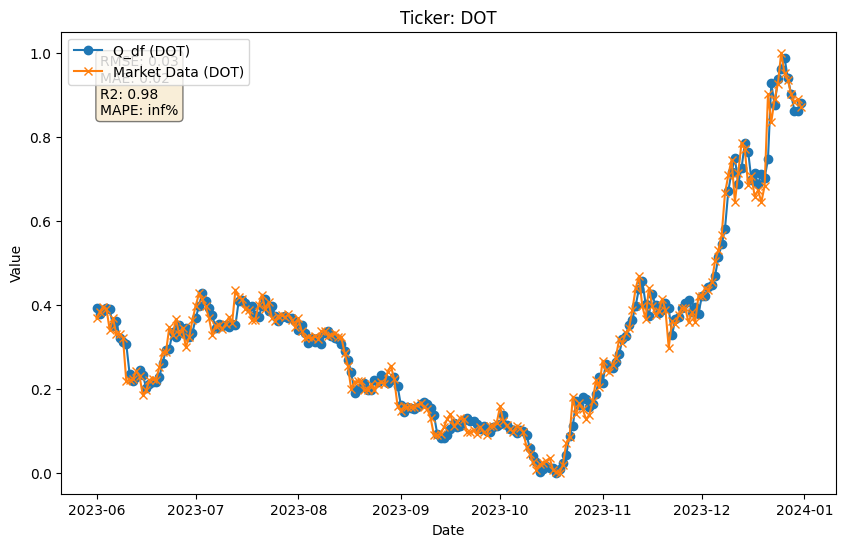

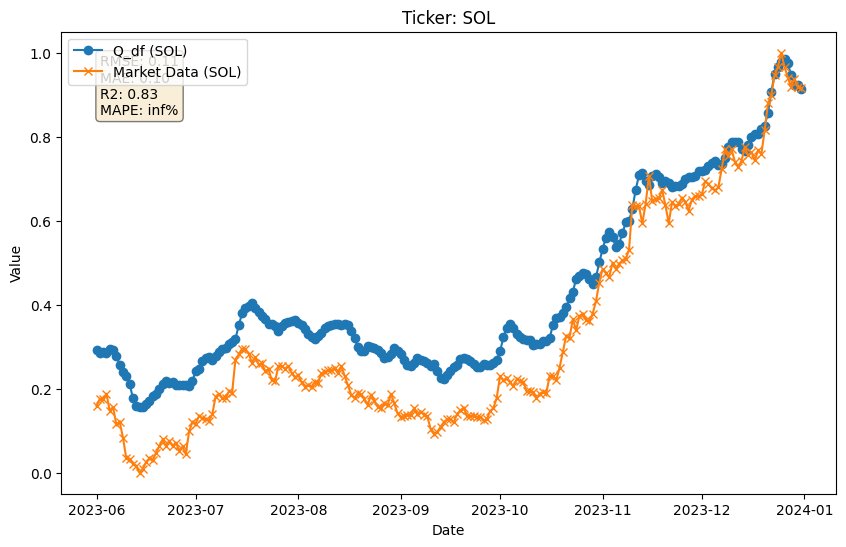

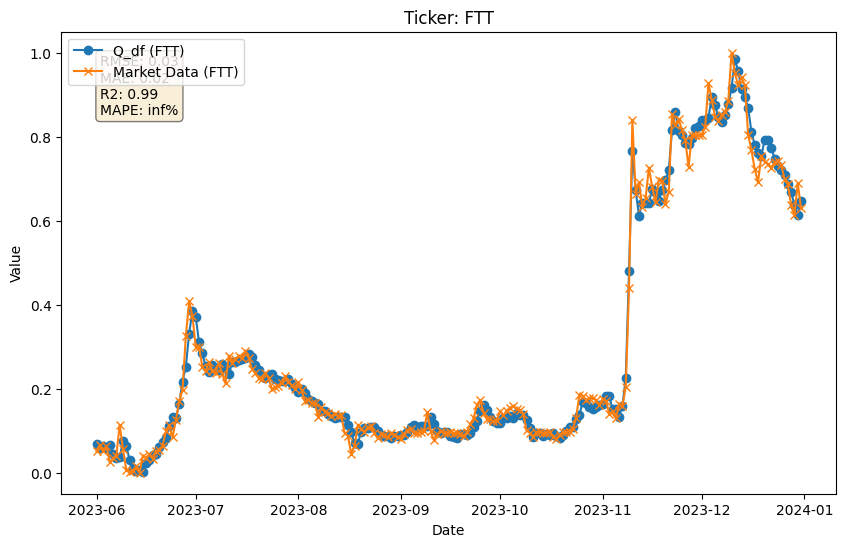

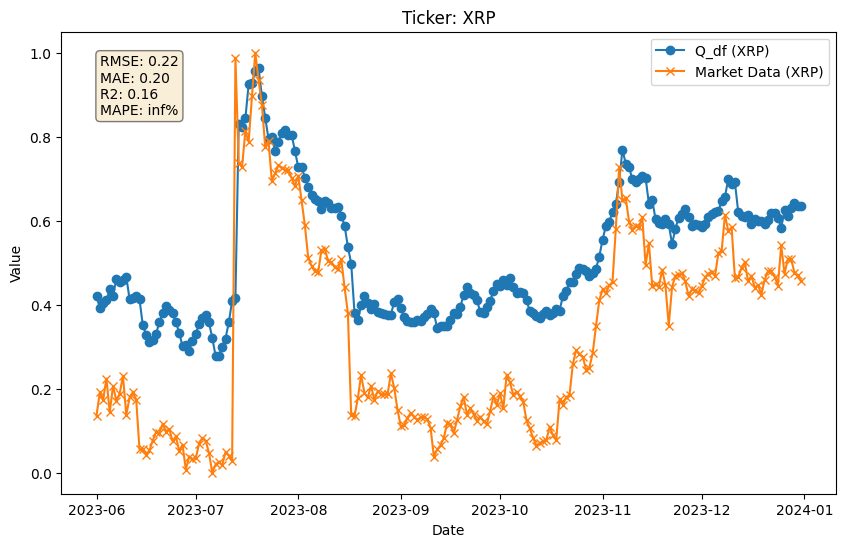

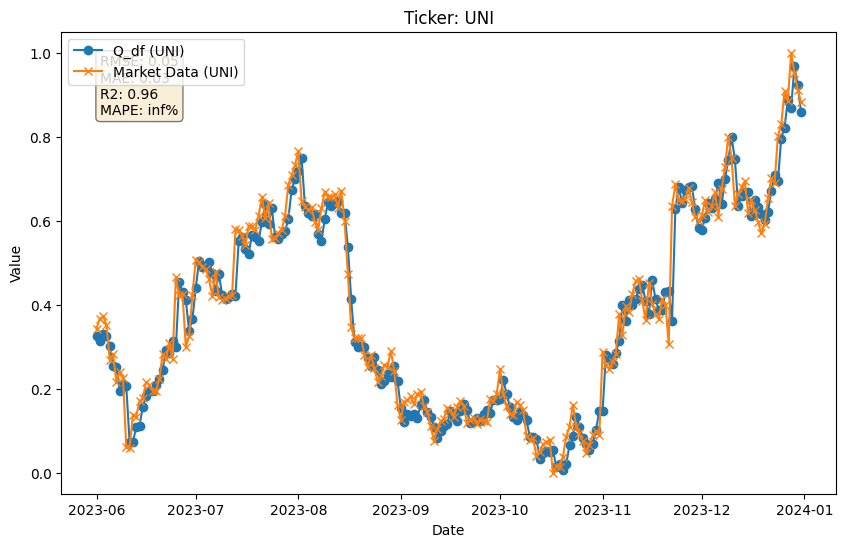

In [23]:
for ticker in tickers:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Q_df와 시장 데이터 플롯
    ax.plot(Q_df.loc[ticker].index, Q_df.loc[ticker], label=f'Q_df ({ticker})', marker='o')
    ax.plot(transformed_market_data.loc[ticker].index, transformed_market_data.loc[ticker], label=f'Market Data ({ticker})', marker='x')

    # 오차 지표 추가
    metrics = results[ticker]
    textstr = '\n'.join((
        f'RMSE: {metrics["RMSE"]:.2f}',
        f'MAE: {metrics["MAE"]:.2f}',
        f'R2: {metrics["R2"]:.2f}',
        f'MAPE: {metrics["MAPE"]:.2f}%'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # 그래프 설정
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'Ticker: {ticker}')
    ax.legend()
    plt.show()